In [74]:
from pylab import *
import scipy.integrate
import time

# Computation of diffusive $\gamma$-ray emission and comparison between cosmic rays flux models

## 1. Galactic gas

### GALPROP

In [194]:
#Importing data
data = np.genfromtxt('Galactic_Gas/gas_Galprop.txt')
radius = data[:,0] * 3.08567758128e21 #in cm
height = data[:,1] * 3.08567758128e21 #in cm
atomic_density = data[:,2] #in cm^-3
molecular_density = data[:,3] #in cm^-3
total_density = (atomic_density + molecular_density) * 1.42 #in cm^-3

In [195]:
Earth_position = 8.5 * 3.08567758128e21 #in cm

#Spherical to cartesian coordinates
def x(s, theta, phi):
    return ( s * math.sin(math.radians(theta)) * math.cos(math.radians(phi)) ) - Earth_position
def y(s, theta, phi):
    return s * math.sin(math.radians(theta)) * math.sin(math.radians(phi))
def z(s, theta):
    return s * math.cos(math.radians(theta))

#Cartesian to cylindircal coordinates
def r(s, theta, phi):
    xx = x(s, theta, phi)
    yy = y(s, theta, phi)
    return np.sqrt(xx**2 + yy**2)

In [196]:
def n(s, theta, phi):
    R = r(s, theta, phi)
    Z = z(s, theta)
    index_height = (np.abs(height - Z)).argmin()
    index_radius = np.where(np.logical_and(height==height[index_height], height==height[index_height]))
    gas = scipy.interpolate.CubicSpline(radius[index_radius], total_density[index_radius])
    return gas(R)
n_GALPROP = np.vectorize(n)

## 2. Cross-section

In [38]:
# Quantities
m_p = 0.938272 # Proton mass in GeV
m_pi = 0.134976 # Pion mass in GeV
T_pth = (2.0 * m_pi) + m_pi**2 / (2.0 * m_p) # Threshold in GeV

# Maximum pi_0 energy
def EpimaxLAB(T_p):
    s = 2.0 * m_p * (T_p + 2.0 * m_p)
    gammaCM = (T_p + 2.0 * m_p) * s**(-1 / 2)
    EpiCM = (s - 4.0 * m_p**2 + m_pi**2) / (2.0 * s**(1 / 2))
    PpiCM = (EpiCM**2 - m_pi**2)**(1 / 2)
    BetaCM = (1.0 - gammaCM**(-2))**(1 / 2)
    EpimaxLABval = gammaCM * (EpiCM + PpiCM * BetaCM)
    return EpimaxLABval # in GeV

# Maximum gamma-ray energy
def Egammamax(T_p):
    gammapiLAB = EpimaxLAB(T_p) / m_pi
    BetapiLAB = (1.0 - gammapiLAB**(-2))**(1 / 2)
    Egmin = (m_pi / 2.0) * gammapiLAB * (1.0 - BetapiLAB)
    Egmax = (m_pi / 2.0) * gammapiLAB * (1.0 + BetapiLAB)
    return Egmax # in GeV

# pp total inelastic cross section (fitting the PDG data including TOTEM @ LHC)
def sigmainel(T_p):
    LX = np.log(T_p / T_pth)
    Thresh = max(0.0, (1.0 - (T_pth / T_p)**1.9))
    XS = (30.7 - 0.96 * LX + 0.18 * LX**2) * Thresh**3
    return XS # in mb

# First pi_0 production cross section. Valid for T_p <= 2 GeV. The channel included is pp->pp(pi_0)
def sigma1pi(T_p):
    MRES = 1.1883 # Resonance effective mass in GeV
    GammaRES = 0.2264 # Resonance effective width in GeV
    sigma0 = 7.66 * 10**(-3) # mb
    if T_p <= T_pth:
        XS1pi = 0.0
    if T_p > 2.0:
        XS1pi = 0.0
    else:
        s = 2.0 * m_p * (T_p + 2.0 * m_p)
        X = s**(1/2) - m_p
        eta = ( ((s - m_pi**2 - 4.0 * m_p**2)**2 - (16.0 * m_pi**2 * m_p**2))**(1/2) ) / (2 * m_pi * s**(1/2))
        gRES = (MRES**2 * (MRES**2 + GammaRES**2))**(1/2)
        KRES = (8.0**(1/2)) * MRES * GammaRES * gRES / (np.pi * (MRES**2 + gRES)**(1/2))
        fBW = m_p * (KRES / ((X**2 - MRES**2)**2 + (MRES * GammaRES)**2))
        XS1pi = sigma0 * (eta**1.95) * (1.0 + eta + eta**5) * (fBW**1.86)
    return XS1pi # in mb

# Second pion production cross section. Valid T_p <= 2 GeV. The channels included are p+p -> p+n +(pi+)+(pi_0), 
# p+p ->  D  +(pi+)+(pi:0), p+p -> p+p +2(pi_0)
def sigma2pi(T_p):
    if T_p < 0.56:
        XS2pi = 0.0
    if T_p > 2.0:
        XS2pi = 0.0
    else:
        XS2pi = 5.7 / (1.0 + np.exp(-9.3 * (T_p - 1.4)))
    return XS2pi # in mb

### Geant4

In [39]:
# Average pi_0 production multiplicity given by Geant4. Valid for T_p >= to 1 GeV
def multippi0Geant4(T_p):
    if T_p <= 2.0:
        multippi0 = 0
    if T_p >= 5.0:
        a1 = 0.728; a2 = 0.596; a3 = 0.491; a4 = 0.2503; a5 = 0.117
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    else: 
        Qp = (T_p - T_pth) / m_p
        multippi0 = -6.0 * 10**-3 + 0.237 * Qp - 0.023 * Qp**2
    return multippi0

# pi_0 production cross section by using experimental data for T_p<=2 GeV, and Geant4 multiplicity for T_p>2 GeV
def sigmapiGeant4(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0Geant4(T_p)
    return XSpi0 # in mb

# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, and for T_p >= 1 GeV is based on Geant4.
def AmaxGeant4(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    if T_p <= T_pth:
        Amax = 0
    if T_p > T_pth and T_p < 1.0:
        Amax = 5.9 * sigmapiGeant4(T_p) / EpimaxLAB(T_p)
    if T_p >= 1.0 and T_p < 5.0:
        b1 = 9.53; b2 = -0.52; b3 = 0.054;
        Amax = b1 * (theta_p**b2) * np.exp(b3 * Ltheta_p**2.0) * sigmapiGeant4(T_p) / m_p
    else: 
        b1 = 9.13; b2 = -0.35; b3 = 9.7 * 10**(-3);
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiGeant4(T_p) / m_p
    return Amax # in mb/GeV

# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV and Geant4 for T_p >= 1 GeV. 
def FGeant4(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    theta = T_p/m_p
    kappa = 3.29 - 0.2 * theta**(-1.5)
    q = (T_p - 1.0) / m_p
    C0 = 3.0 * m_pi / Y0
    FF = 0.0
    if X >= 0.0 and X < 1.0:
        FF = 0.0
        if T_p > T_pth and T_p < 1.0:
            FF = (1 - X)**kappa
        if T_p >= 1.0 and T_p <= 4.0:
            mu = 1.25 * q**1.25 * np.exp(-1.25 * q)
            beta = mu + 2.45
            gamma = mu + 1.45
            FF = (1 - X)**beta / (1 + X / C0)**gamma
        if T_p > 4.0 and T_p <= 20.0:
            mu = 1.25 * q**1.25 * np.exp(-1.25 * q)
            beta = 1.5 * mu + 4.95
            gamma = mu + 1.5
            FF = (1 - X)**beta / (1 + X / C0)**gamma
        if T_p > 20.0 and T_p <= 100.0:
            FF = (1 - X**0.5)**4.2 / (1 + X / C0)
        if T_p > 100.0: 
            FF = (1 - X**0.5)**4.9 / (1 + X / C0)
    return FF

# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for T_p >= 1 GeV.
def dsigmadEgammaGeant4(T_p, Egamma):
    dsigma = AmaxGeant4(T_p) * FGeant4(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossGeant4 = vectorize(dsigmadEgammaGeant4)

### Pythia8

In [41]:
# Average pi_0 production multiplicity given by Geant4 for T_p <= 50 GeV and Pythia 8 for T_p > 50 GeV
def multippi0Pythia8(T_p):
    if T_p <= 50.0:
        multippi0 = multippi0Geant4(T_p)
    else: 
        a1 = 0.652; a2 = 0.0016; a3 = 0.488; a4 = 0.1928; a5 = 0.483
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    return multippi0

# pi_0 production cross section by using experimental data for T_p <= 2 GeV, 
# Geant4 multiplicity for 2 < T_p <= 50 GeV and Pythia8 multiplicity for T_p < 50 GeV
def sigmapiPythia8(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0Pythia8(T_p)
    return XSpi0 # in mb

# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, for 1 <= T_p <= 50 GeV is based on Geant4 and 
# for T_p > 50 GeV is based on Pythia8.
def AmaxPythia8(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    if T_p <= T_pth:
        Amax = 0
    if T_p > T_pth and T_p <= 50.0:
        Amax = AmaxGeant4(T_p)
    if T_p > 50.0:
        b1 = 9.06; b2 = -0.3795; b3 = 0.01105;
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiPythia8(T_p) / m_p
    return Amax # in mb/GeV

# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV Geant4 for 1 <= T_p <= 50 GeV and Pythia8 for T_p > 50 GeV
def FPythia8(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    C0 = 3.5 * m_pi / Y0
    if X >= 0.0 and X < 1.0 and T_p > 50:
        FF = (1 - X**0.5)**4.0 / (1 + X / C0)
    else:
        FF = FGeant4(T_p, Egamma)
    return FF

# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for 1 <= T_p <= 50 GeV and Pythia8 for T_p > 50 GeV
def dsigmadEgammaPythia8(T_p, Egamma):
    dsigma = AmaxPythia8(T_p) * FPythia8(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossPythia8 = vectorize(dsigmadEgammaPythia8)

### SIBYLL

In [42]:
# Average pi0 production multiplicity given by Geant4 for T_p <= 100 GeV and SIBYLL for T_p>100 GeV
def multippi0SYBILL(T_p): 
    if T_p <= 100.0:
        multippi0 = multippi0Geant4(T_p)
    else:
        a1 = 5.436; a2 = 0.254; a3 = 0.072; a4 = 0.075; a5 = 0.166
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    return multippi0

# pi_0 production cross section by using experimental data for T_p <= 2 GeV, 
# Geant4 multiplicity for 2 < T_p <= 100 GeV and SIBYLL multiplicity for T_p > 100 GeV
def sigmapiSIBYLL(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0SYBILL(T_p)
    return XSpi0 # in mb

# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, for 1 <= T_p <= 100 GeV is based on Geant4
# and for T_p > 100 GeV is based on SIBYLL.
def AmaxSIBYLL(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    if T_p > T_pth and T_p <= 100.0:
        Amax = AmaxGeant4(T_p)
    if T_p > 100.0:
        b1 = 10.77; b2 = -0.412; b3 = 0.01264;
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiSIBYLL(T_p) / m_p
    return Amax # in mb/GeV

# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV Geant4 for 1 <= T_p <= 100 GeV and SIBYLL for T_p > 100 GeV
def FSIBYLL(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    C0 = 3.55 * m_pi / Y0
    if X >= 0.0 and X < 1.0 and T_p > 100:
        FF = (1 - X**0.5)**3.6 / (1 + X / C0)
    else:
        FF = FGeant4(T_p, Egamma)
    return FF

# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for for 1 <= T_p <= 100 GeV and SIBYLL for T_p > 100 GeV
def dsigmadEgammaSIBYLL(T_p, Egamma):
    dsigma = AmaxSIBYLL(T_p) * FSIBYLL(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossSIBYLL = vectorize(dsigmadEgammaSIBYLL)

### QGSJET

In [43]:
# Average pi0 production multiplicity given by Geant4 for T_p <= 100 GeV and QGSJET for T_p>100 GeV  
def multippi0QGSJET(T_p):
    if T_p <= 100.0:
        multippi0 = multippi0Geant4(T_p)
    else: 
        a1 = 0.908; a2 = 0.0009; a3 = 6.089; a4 = 0.176; a5 = 0.448
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    return multippi0

# pi_0 production cross section by using experimental data for T_p <= 2 GeV, 
# Geant4 multiplicity for 2 < T_p <= 100 GeV and QGSJET multiplicity for T_p > 100 GeV
def sigmapiQGSJET(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0QGSJET(T_p)
    return XSpi0 # in mb

# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, for 1 <= T_p <= 100 GeV is based on Geant4
# and for T_p > 100 GeV is based on QGSJET.
def AmaxQGSJET(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    #if T_p > T_pth and T_p <= 100.0:
    if T_pth < T_p <= 100:
        Amax = AmaxGeant4(T_p)
    if T_p > 100.0:
        b1 = 13.16; b2 = -0.4419; b3 = 0.01439;
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiQGSJET(T_p) / m_p
    return Amax # in mb/GeV

# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV Geant4 for 1 <= T_p <= 100 GeV and QGSJET for T_p > 100 GeV
def FQGSJET(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    C0 = 3.55 * m_pi / Y0
    if X >= 0.0 and X < 1.0 and T_p > 100:
        FF = (1 - X**0.5)**4.5 / (1 + X / C0)
    else:
        FF = FGeant4(T_p, Egamma)
    return FF

# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for for 1 <= T_p <= 100 GeV and QGSJET for T_p > 100 GeV
def dsigmadEgammaQGSJET(T_p, Egamma):
    dsigma = AmaxQGSJET(T_p) * FQGSJET(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossQGSJET = vectorize(dsigmadEgammaQGSJET)

## 3. Cosmic ray flux

### Dembinski

In [44]:
data = np.genfromtxt('Cosmic_Rays/CRdatadriven.txt')
E_Dembinski = data[:,0]
# Data is in (GeV cm^2 s sr)^-1, have to be renormalized
phi_p_Dembinski = data[:,1] * 1e4
phi_He_Dembinski = data[:,2] * 1e4
phi_Dembinski = np.zeros((len(data[:,0]), len((data[0,:]))))
phi_total_Dembinski = np.zeros(len(data[:,0]))
for i in range(1,29):
    phi_Dembinski[:,i] = data[:,i] * 1e4
    phi_total_Dembinski += phi_Dembinski[:,i]

### Prevotat

### Lipari + my extension

In [45]:
# Model for proton
def Phi_proton_nucleon(E):
    n = 1
    K = 0.0447834 * n
    E0 = 0.1 / n
    alpha1 = 2.805; alpha2 = 2.56; alpha3 = 2.805; alpha4 = 0.647; alpha5 = 4.363
    omega1 = 0.28; omega2 = 0.163; omega3 = 0.976; omega4 = 1.449
    Eb1 = 0.670 / n; Eb2 = 16 / n; Eb3 = 0.687 / n; Eb4 = 3.874 / n
    delta1 = alpha2 - alpha1
    delta2 = alpha3 - alpha2
    delta3 = alpha4 - alpha3
    delta4 = alpha5 - alpha4
    phi = K * ((E/1e3) / E0)**(-alpha3) * (1 + ((E/1e3) / Eb1)**(1 / omega1))**(-delta1 * omega1) * (1 + ((E/1e3) / Eb2)**(1 / omega2))**(-delta2 * omega2) * (1 + ((E/1e6) / Eb3)**(1 / omega3))**(-delta3 * omega3) * (1 + ((E/1e6) / Eb4)**(1 / omega4))**(-delta4 * omega4)
    return phi

# Model for He
def Phi_He_nucleon(E):
    n = 4
    K = 0.0332401 * n
    E0 = 0.1 / n
    alpha1 = 2.715; alpha2 = 2.474; alpha3 = 2.734; alpha4 = 2.04; alpha5 = 4.477
    omega1 = 0.28; omega2 = 0.011; omega3 = 0.1; omega4 = 0.934
    Eb1 = 1.204 / n; Eb2 = 32.021 / n; Eb3 = 0.61 / n; Eb4 = 6.262 / n
    delta1 = alpha2 - alpha1
    delta2 = alpha3 - alpha2
    delta3 = alpha4 - alpha3
    delta4 = alpha5 - alpha4
    phi = K * ((E/1e3) / E0)**(-alpha3) * (1 + ((E/1e3) / Eb1)**(1 / omega1))**(-delta1 * omega1) * (1 + ((E/1e3) / Eb2)**(1 / omega2))**(-delta2 * omega2) * (1 + ((E/1e6) / Eb3)**(1 / omega3))**(-delta3 * omega3) * (1 + ((E/1e6) / Eb4)**(1 / omega4))**(-delta4 * omega4)
    return phi

# Model for He
def Phi_heavy_nucleon(E):
    phi = Phi_He_nucleon(E) * f
    return phi


# Model for He
def Phi_total_nucleon(E):
    phi = phi_proton_nucleon + phi_He_nucleon + phi_heavy_nucleon
    return phi

## 4. Optical depth

In [46]:
htagliatoC = 197.4 * 1e6 * 1e-13 #in eV cm
KB = 8.6 * 1e-5 #in eV K^-1
Relectron = 2.8179 * 10e-15 * 1e2 #in cm
htagliato = 6.58 * 1e-16 #in eV s
MassaE = 0.511 * 1e-6 #in TeV
MassaP = 938.27 * 1e-6 #in TeV
CaricaElettrone = 4.8 * 1e10 #in cm^(3/2) g^(1/2) s^-1
SigmaT = 6.65 * 1e-29 * 1e4 #in cm^2
kpctocm = 1e3 * 3.26 * 3.15 * 1e7 * 3.0 * 1e10

In [47]:
def xx1(Eg, ee, theta): 
    #ee in eV, Eg in GeV
    xx = 2 * Eg * ee * 1e-15 * ((1 - np.cos(theta)) / (4 * MassaE**2))
    return xx
vec_xx1 = np.vectorize(xx1)

In [48]:
def beta2(xx):
    if xx >= 1:
        beta = (1 - (1.0 / xx))**(0.5)
    if xx < 1:
        beta = 0
    return beta
vec_beta2 = np.vectorize(beta2)

In [49]:
def sigmaGG(beta):
    sigma = SigmaT * (3 / 16) * (1 - beta**2) * (2 * beta * (beta**2 - 2) + (3 - beta**4) * np.log((1 + beta) / (1 - beta)))
    return sigma
vec_sigmaGG = np.vectorize(sigmaGG)

In [50]:
def Ethr(ee, theta):
    E = 2 * MassaE / (ee * 1e-15 * (1 - np.cos(theta)))
    return E
vec_Ethr = np.vectorize(Ethr)

In [51]:
# Black body distribution
def n_bb(ee, T):
    n = (np.pi**2 * htagliatoC**3)**(-1) * (ee**2 / (np.exp(ee / (KB * T)) - 1))
    return n #in eV^(-1) cm^(-3)
vec_n_bb = np.vectorize(n_bb)

def n_bb_ee(ee, T):
    n = (np.pi**2 * htagliatoC**3)**(-1) * (ee**2 / (np.exp(ee / (KB * T)) - 1)) * ee
    return n #in cm^(-3)
vec_n_bb_ee = np.vectorize(n_bb_ee)

In [52]:
def EnergyDensityBB(T, nn):
    density = nn * scipy.integrate.quad(n_bb_ee, 0, 50 * KB * T, args=T) 
    return density #in eV cm^(-3)
vec_EnergyDensityBB = np.vectorize(EnergyDensityBB)

In [53]:
def integrand(ee, theta, T, Eg):
    integrand_value = np.sin(theta) * (1 - np.cos(theta)) * n_bb(ee, T) * sigmaGG(beta2(xx1(Eg, ee, theta)))
    return integrand_value
    
def KKProva(Eg, T):
    #integral = scipy.integrate.dblquad(integrand, 0, 500 * KB * T, 0, np.pi, args=(T, Eg))
    integral = scipy.integrate.dblquad(integrand, 0, np.pi, 0, 500 * KB * T, args=(T, Eg))
    #integral = scipy.integrate.dblquad(integrand, 0.0, np.pi, lambda x: 0.0, lambda x: 500 * KB * T, args=(T, Eg))
    KK = 2 * np.pi * kpctocm * integral[0]
    return KK #in kpc^(-1)
vec_KKProva = vectorize(KKProva)

In [54]:
#def KK1(Eg):
    #KK = KKProva(Eg, 2.7255)
    #return KK
#vec_KK1 = np.vectorize(KK1)

logEg = np.arange(0, 7.07, 7/100)
Table = np.array((10**logEg, vec_KKProva(10**logEg, 2.7255)))
KK1 = scipy.interpolate.CubicSpline(Table[0,:], Table[1,:])

In [197]:
def tauABSiso(Eg, los):
    r = los / 3.08567758128e21 #cm to kpc
    tau = KK1(Eg) * r / (4 * np.pi)
    return tau
vec_tauABSiso = np.vectorize(tauABSiso)

## Computation of diffusive gamma ray emission

In [214]:
def I_gamma(Egamma, theta, phi, gas_model, hadronic_model, cr_model):
    
    # Egamma - Gamma-ray energy [GeV]
    # theta - Latitude angle [degrees]
    # phi - Longitude angle [degrees]
    # gas_model - Options: GALPROP
    # hadronic_model - Options: Geant4, Pythia8, SIBYLL, QGSJET
    # cr_model = Options: Dembinski, Lipari
    
    indexE = np.where(np.logical_and(E_Dembinski>=Egamma, E_Dembinski>=Egamma))
    Ep = E_Dembinski[indexE]
    
    # FIRST INTEGRAL
    
    # Cross-section model
    if hadronic_model == 'Geant4':
        dsigmadE = diffcrossGeant4(Ep, Egamma) * 1e-27
    if hadronic_model == 'Pythia8':
        dsigmadE = diffcrossPythia8(Ep, Egamma) * 1e-27
    if hadronic_model == 'SIBYLL':
        dsigmadE = diffcrossSIBYLL(Ep, Egamma) * 1e-27
    if hadronic_model == 'QGSJET':
        dsigmadE = diffcrossQGSJET(Ep, Egamma) * 1e-27
        
    # Cosmic rays model
    if cr_model == 'Dembinski':
        flux_CR = phi_total_Dembinski[indexE] / 1e4
    if cr_model == 'Lipari':
        flux_CR = Phi_proton_nucleon(Ep) / 1e4
        
    integral_E = scipy.integrate.simpson(dsigmadE * flux_CR, Ep)
        
    # SECOND INTEGRAL
    
    # Gas model
    los = np.arange(0, 50, 0.1) * 3.08567758128e21 # in cm
    if gas_model == 'GALPROP':
        n_gas = n_GALPROP(los, theta, phi)
        
    # Optical depth
    tau = vec_tauABSiso(Egamma, los)
    
    intensity = scipy.integrate.simpson(n_gas * np.exp(-tau) * integral_E, los)
    
    return intensity #in (GeV cm^2 s sr)^-1
vec_I_gamma = np.vectorize(I_gamma)

In [199]:
start_time = time.time()
intensity = vec_I_gamma(100, 90, 90, 'GALPROP', 'Pythia8', 'Dembinski')
print("Run time: %s seconds" % (time.time() - start_time))

Run time: 0.22044014930725098 seconds


In [200]:
vec_I_gamma(1e-1, 0, 0, 'GALPROP', 'Pythia8', 'Dembinski')

array(2.91099307e-05)

## Comparison of cross-section models

In [201]:
Energy_gamma = E_Dembinski

Igamma_Lipari_Geant4 = vec_I_gamma(Energy_gamma, 0, 0, 'GALPROP', 'Geant4', 'Lipari')
Igamma_Lipari_Pythia8 = vec_I_gamma(Energy_gamma, 0, 0, 'GALPROP', 'Pythia8', 'Lipari')
Igamma_Lipari_SIBYLL = vec_I_gamma(Energy_gamma, 0, 0, 'GALPROP', 'SIBYLL', 'Lipari')
Igamma_Lipari_QGSJET = vec_I_gamma(Energy_gamma, 0, 0, 'GALPROP', 'QGSJET', 'Lipari')
Igamma_Dembinski_Geant4 = vec_I_gamma(Energy_gamma, 0, 0, 'GALPROP', 'Geant4', 'Dembinski')
Igamma_Dembinski_Pythia8 = vec_I_gamma(Energy_gamma, 0, 0, 'GALPROP', 'Pythia8', 'Dembinski')
Igamma_Dembinski_SIBYLL = vec_I_gamma(Energy_gamma, 0, 0, 'GALPROP', 'SIBYLL', 'Dembinski')
Igamma_Dembinski_QGSJET = vec_I_gamma(Energy_gamma, 0, 0, 'GALPROP', 'QGSJET', 'Dembinski')

/var/folders/j4/1fvnmc755y74k9kgn5w7_s400000gn/T/ipykernel_10386/459530710.py:34: RuntimeWarning: overflow encountered in exp
  intensity = scipy.integrate.simpson(n_gas * np.exp(-tau) * integral_E, los)
/var/folders/j4/1fvnmc755y74k9kgn5w7_s400000gn/T/ipykernel_10386/459530710.py:34: RuntimeWarning: invalid value encountered in multiply
  intensity = scipy.integrate.simpson(n_gas * np.exp(-tau) * integral_E, los)


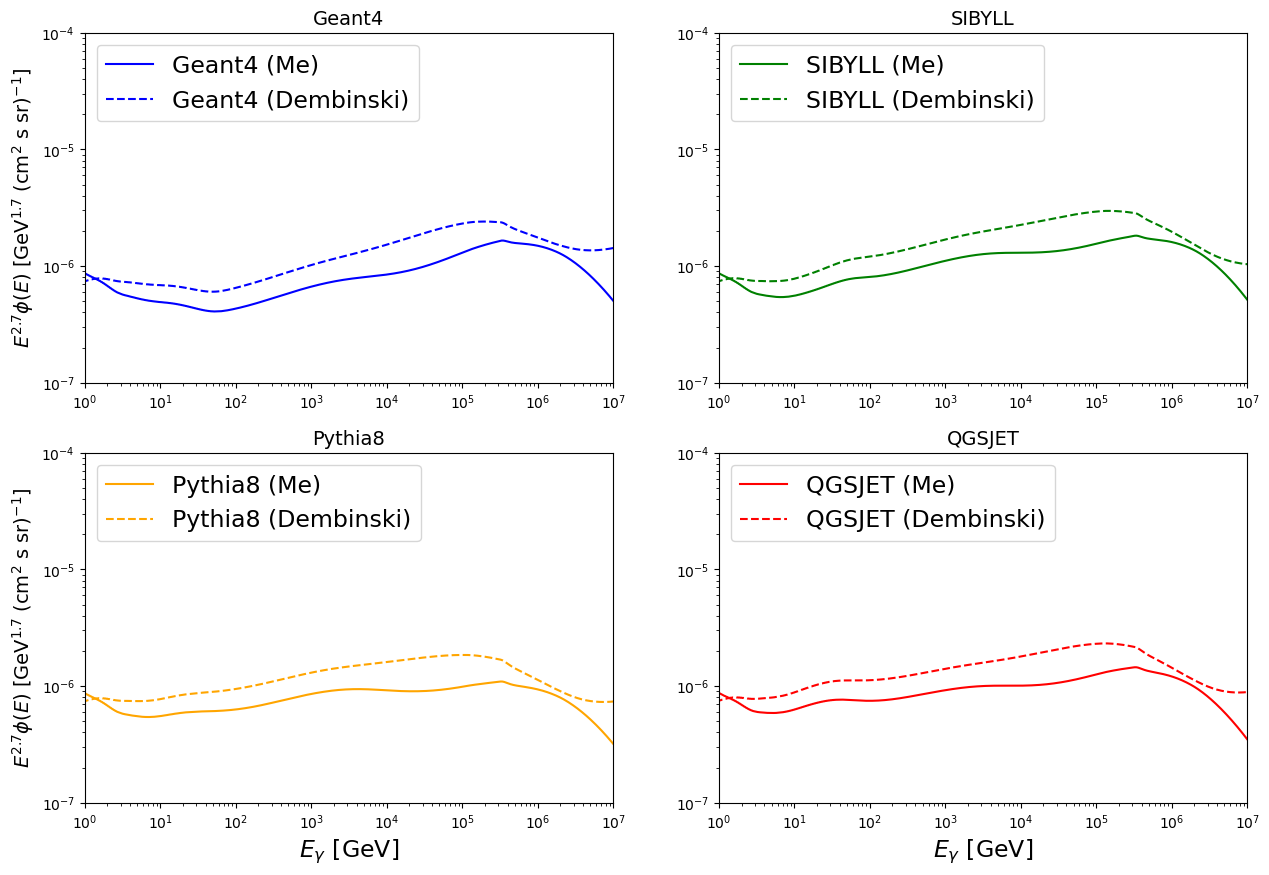

In [213]:
alpha = 2.7
lim = 630

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
#
ax[0,0].plot(Energy_gamma[0:lim], Igamma_Lipari_Geant4[0:lim] * Energy_gamma[0:lim]**alpha, color='blue', label='Geant4 (Me)')
ax[0,0].plot(Energy_gamma[0:lim], Igamma_Dembinski_Geant4[0:lim] * Energy_gamma[0:lim]**alpha, linestyle='--', color='blue', label='Geant4 (Dembinski)')
ax[0,0].loglog()
ax[0,0].set_xlim(1e0, 1e7)
ax[0,0].set_ylim(1e-7, 1e-4)
ax[0,0].set_ylabel(r'$E^{2.7}\phi(E)$ [GeV$^{1.7}$ (cm$^2$ s sr)$^{-1}$]', fontsize=14)
ax[0,0].legend(ncol=1, fontsize=17, loc='upper left')
ax[0,0].set_title('Geant4', fontsize=14)
#
ax[1,0].plot(Energy_gamma[0:lim], Igamma_Lipari_Pythia8[0:lim] * Energy_gamma[0:lim]**alpha, color='orange', label='Pythia8 (Me)')
ax[1,0].plot(Energy_gamma[0:lim], Igamma_Dembinski_Pythia8[0:lim] * Energy_gamma[0:lim]**alpha, linestyle='--', color='orange', label='Pythia8 (Dembinski)')
ax[1,0].loglog()
ax[1,0].set_xlim(1e0, 1e7)
ax[1,0].set_ylim(1e-7, 1e-4)
ax[1,0].set_ylabel(r'$E^{2.7}\phi(E)$ [GeV$^{1.7}$ (cm$^2$ s sr)$^{-1}$]', fontsize=14)
ax[1,0].set_xlabel(r'$E_\gamma$ [GeV]', fontsize=17)
ax[1,0].legend(ncol=1, fontsize=17, loc='upper left')
ax[1,0].set_title('Pythia8', fontsize=14)
#
ax[0,1].plot(Energy_gamma[0:lim], Igamma_Lipari_SIBYLL[0:lim] * Energy_gamma[0:lim]**alpha, color='green', label='SIBYLL (Me)')
ax[0,1].plot(Energy_gamma[0:lim], Igamma_Dembinski_SIBYLL[0:lim] * Energy_gamma[0:lim]**alpha, linestyle='--', color='green', label='SIBYLL (Dembinski)')
ax[0,1].loglog()
ax[0,1].set_xlim(1e0, 1e7)
ax[0,1].set_ylim(1e-7, 1e-4)
ax[0,1].legend(ncol=1, fontsize=17, loc='upper left')
ax[0,1].set_title('SIBYLL', fontsize=14)
#
ax[1,1].plot(Energy_gamma[0:lim], Igamma_Lipari_QGSJET[0:lim] * Energy_gamma[0:lim]**alpha, color='red', label='QGSJET (Me)')
ax[1,1].plot(Energy_gamma[0:lim], Igamma_Dembinski_QGSJET[0:lim] * Energy_gamma[0:lim]**alpha, linestyle='--', color='red', label='QGSJET (Dembinski)')
ax[1,1].loglog()
ax[1,1].set_xlim(1e0, 1e7)
ax[1,1].set_ylim(1e-7, 1e-4)
ax[1,1].set_xlabel(r'$E_\gamma$ [GeV]', fontsize=17)
ax[1,1].legend(ncol=1, fontsize=17, loc='upper left')
ax[1,1].set_title('QGSJET', fontsize=14)
#
plt.savefig('Plots/gamma_comparison_overall.png')

In [204]:
# Addition of Fermi-LAT data
E_Fermi = np.genfromtxt('Fermi/E_center.txt')
flux_Fermi = np.genfromtxt('Fermi/flux.txt')
error_y = np.genfromtxt('Fermi/yerr.txt') / E_Fermi**2
error_x_up = np.genfromtxt('Fermi/xerr_up.txt') 
error_x_down = np.genfromtxt('Fermi/xerr_do.txt') 

# MeV to GeV
E_Fermi = E_Fermi * 1e-3
# (MeV cm^2 s sr)^-1 to (GeV cm^2 s sr)^-1
flux_Fermi = flux_Fermi / 1e-3
error_x_up = error_x_up * 1e-3
error_x_down = error_x_down * 1e-3
error_y = error_y / 1e-3

In [239]:
# Inner Galaxy
b_inner = np.arange(-4,5)
l_inner = np.arange(16, 125, 10)

# Outer Galaxy
b_outer = np.arange(-4,5)
l_outer = np.arange(126,235, 10)

len(b_inner) * len(l_inner)

54

In [ ]:
# Inner Galaxy spectrum
start_time = time.time()
Igamma_Lipari_Pythia8_innerGalaxy = np.zeros(len(Energy_gamma))
for i in range(0, len(b_inner)):
    for j in range(0, len(l_inner)):
        Igamma_Lipari_Pythia8_innerGalaxy += vec_I_gamma(Energy_gamma, b_inner[i], l_inner[j], 'GALPROP', 'Pythia8', 'Lipari')
print("Run time: %s seconds" % (time.time() - start_time))

# Outer Galaxy spectrum

Text(0.5, 1.0, 'Diffusive gamma-ray spectrum (only protons)')

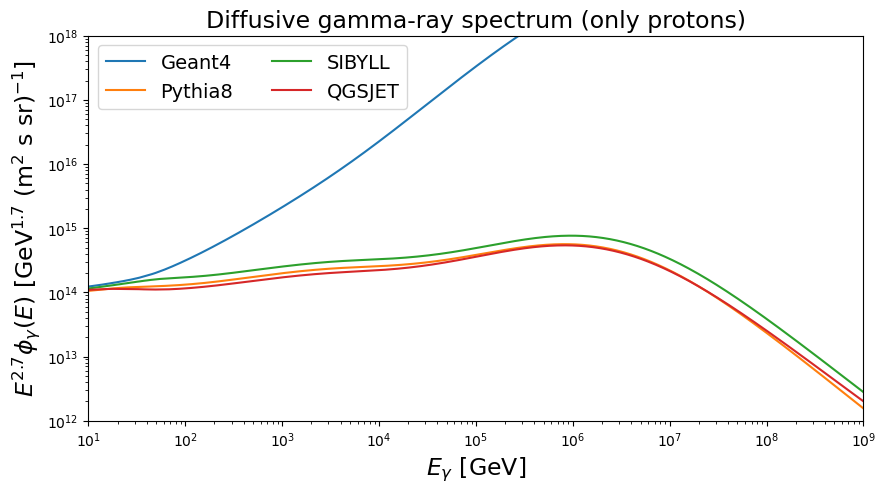

In [115]:
alpha = 2.7

plt.figure(figsize=(10, 5))
plt.plot(Energy_gamma, Igamma_Geant4 * Energy_gamma**alpha, label='Geant4')
plt.plot(Energy_gamma, Igamma_Pythia8 * Energy_gamma**alpha, label='Pythia8')
plt.plot(Energy_gamma, Igamma_SIBYLL * Energy_gamma**alpha, label='SIBYLL')
plt.plot(Energy_gamma, Igamma_QGSJET * Energy_gamma**alpha, label='QGSJET')
plt.loglog()
plt.ylim(1e12, 1e18)
plt.xlim(1e1, 1e9)
plt.xlabel(r'$E_\gamma$ [GeV]', fontsize=17)
plt.ylabel(r'$E^{2.7}\phi_\gamma(E)$ [GeV$^{1.7}$ (m$^2$ s sr)$^{-1}$]', fontsize=17)
plt.legend(ncol=2, fontsize=14, loc='upper left')
plt.title('Diffusive gamma-ray spectrum (only protons)', fontsize=17)

## Comparison of cosmic ray models

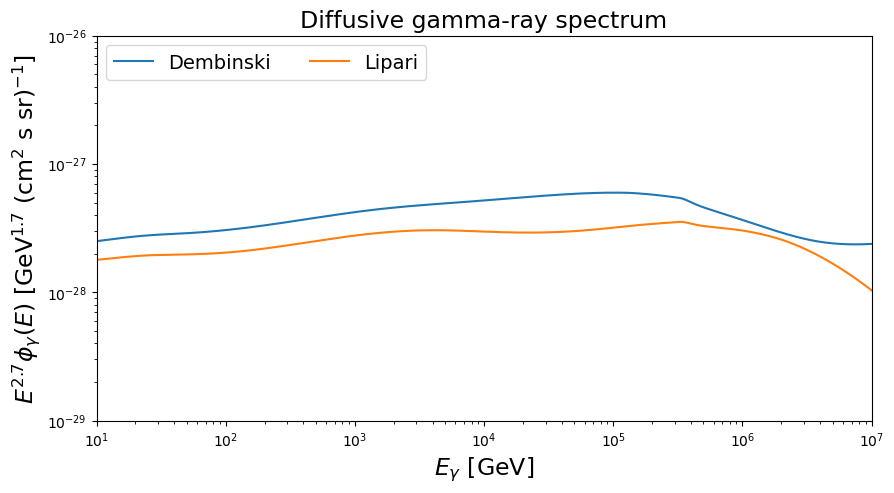

In [162]:
alpha = 2.7
lim = 630

plt.figure(figsize=(10, 5))
plt.plot(Energy_gamma[0:lim], Igamma_Dembinski[0:lim] * Energy_gamma[0:lim]**alpha, label='Dembinski')
plt.plot(Energy_gamma[0:lim], Igamma_Lipari[0:lim] * Energy_gamma[0:lim]**alpha, label='Lipari')
plt.loglog()
plt.ylim(1e-29, 1e-26)
plt.xlim(1e1, 1e7)
plt.xlabel(r'$E_\gamma$ [GeV]', fontsize=17)
plt.ylabel(r'$E^{2.7}\phi_\gamma(E)$ [GeV$^{1.7}$ (cm$^2$ s sr)$^{-1}$]', fontsize=17)
plt.legend(ncol=2, fontsize=14, loc='upper left')
plt.title('Diffusive gamma-ray spectrum', fontsize=17)
plt.savefig('Plots/gamma_comparison_crflux.png')

Text(0.5, 1.0, 'Diffusive gamma-ray spectrum (only protons)')

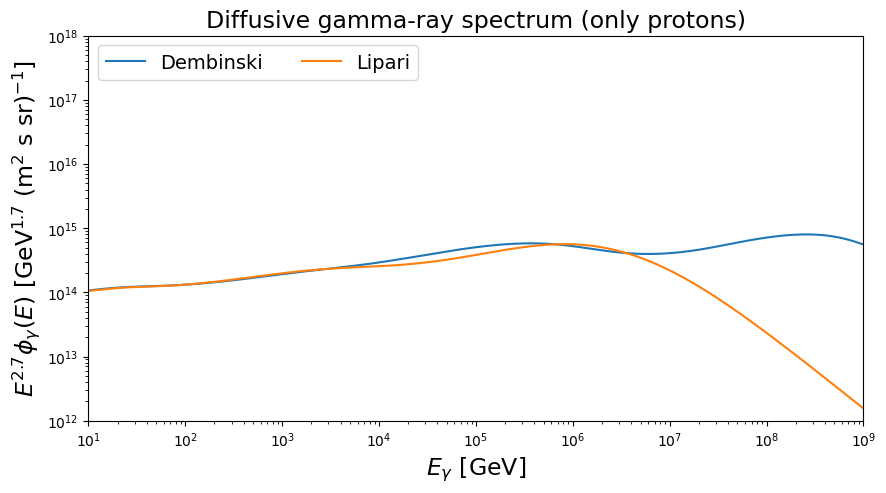

In [116]:
alpha = 2.7

plt.figure(figsize=(10, 5))
plt.plot(Energy_gamma, Igamma_Dembinski * Energy_gamma**alpha, label='Dembinski')
plt.plot(Energy_gamma, Igamma_Lipari * Energy_gamma**alpha, label='Lipari')
plt.loglog()
plt.ylim(1e12, 1e18)
plt.xlim(1e1, 1e9)
plt.xlabel(r'$E_\gamma$ [GeV]', fontsize=17)
plt.ylabel(r'$E^{2.7}\phi_\gamma(E)$ [GeV$^{1.7}$ (m$^2$ s sr)$^{-1}$]', fontsize=17)
plt.legend(ncol=2, fontsize=14, loc='upper left')
plt.title('Diffusive gamma-ray spectrum (only protons)', fontsize=17)